Creación del entorno Ms-Pac-Man

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf

In [3]:
env = gym.make("MsPacman-v0")

In [4]:
obs = env.reset()

In [5]:
obs.shape # [altura, anchura, canales]

(210, 160, 3)

In [6]:
env.action_space

Discrete(9)

Como se puede ver, hay nueve acciones discretas disponibles, que corresponden a las nueve posiciones posibles del joystick (izquierda, derecha, arriba, abajo, centro, superior izquierda, etc.), y las observaciones son simplemente capturas de pantalla de la pantalla Atari

Estas imágenes son un poco grandes, por lo que crearemos una pequeña función de preprocesamiento que recortará la imagen y la reducirá a 88 × 80 píxeles, la convertirá a escala de grises y mejorará el contraste de la Sra. Pac-Man. Esto reducirá la cantidad de cálculos requeridos por el DQN y acelerará el entrenamiento.

In [7]:
mspacman_color = np.array([210, 164, 74]).mean()

In [8]:
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [9]:
def preprocess_observation(obs):
    img = obs[1:176:2, ::2] # recortar y reducir tamaño
    img = img.mean(axis=2) # a escala de grises
    img[img==mspacman_color] = 0 # improve contrast
    img = (img - 128) / 128 - 1 # normalize from -1. to 1.
    return img.reshape(88, 80, 1)

In [10]:
img = preprocess_observation(obs)

Saving figure preprocessing_plot


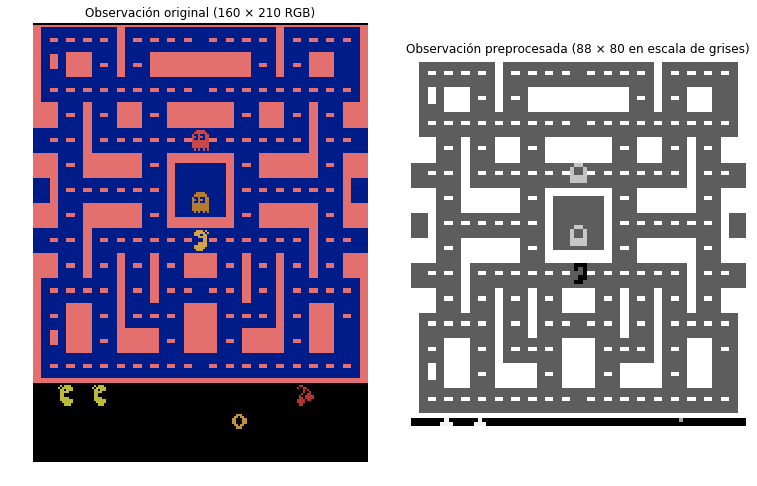

In [11]:
plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("Observación original (160 × 210 RGB)")
plt.imshow(obs)
plt.axis("off")
plt.subplot(122)
plt.title("Observación preprocesada (88 × 80 en escala de grises)")
plt.imshow(img.reshape(88, 80), interpolation="nearest", cmap="gray")
plt.axis("off")
save_fig("preprocessing_plot")
plt.show()

A continuación, vamos a crear el DQN. Simplemente podría tomar un par estado-acción (s, a) como entrada y generar una estimación de
el Q-Value Q (s, a) correspondiente, pero como las acciones son discretas, es más conveniente utilizar una red neuronal que tome solo un estado s como entrada y genere una estimación de Q-Value por acción. El DQN estará compuesto por tres capas convolucionales, seguidas por dos capas totalmente conectadas, incluida la capa de salida

![imagen](images/model.png)

Como veremos, el algoritmo de entrenamiento que usaremos requiere dos DQN con la misma arquitectura (pero con diferentes parámetros): uno se usará para conducir a la Sra. Pac-Man durante el entrenamiento (el actor), y el otro observará al actor y Aprende de sus pruebas y errores (la crítica). A intervalos regulares copiaremos la crítica al actor. Ya que necesitamos dos DQN idénticos, crearemos una función q_network () para construirlos:

In [13]:
input_height = 88
input_width = 80
input_channels = 1
conv_n_maps = [32, 64, 64]
conv_kernel_sizes = [(8,8), (4,4), (3,3)]
conv_strides = [4, 2, 1]
conv_paddings = ["SAME"] * 3
conv_activation = [tf.nn.relu] * 3
n_hidden_in = 64 * 11 * 10 # conv3 tiene 64 mapas de 11x10 cada uno
n_hidden = 512
hidden_activation = tf.nn.relu
n_outputs = env.action_space.n # 9 acciones discretas están disponibles
initializer = tf.contrib.layers.variance_scaling_initializer()

In [16]:
def q_network(X_state, name):
    prev_layer = X_state / 128.0 # scale pixel intensities to the [-1.0, 1.0] range.
    with tf.variable_scope(name) as scope:
        for n_maps, kernel_size, strides, padding, activation in zip(
                conv_n_maps, conv_kernel_sizes, conv_strides,
                conv_paddings, conv_activation):
            prev_layer = tf.layers.conv2d(
                prev_layer, filters=n_maps, kernel_size=kernel_size,
                strides=strides, padding=padding, activation=activation,
                kernel_initializer=initializer)
        last_conv_layer_flat = tf.reshape(prev_layer, shape=[-1, n_hidden_in])
        hidden = tf.layers.dense(last_conv_layer_flat, n_hidden,
                                 activation=hidden_activation,
                                 kernel_initializer=initializer)
        outputs = tf.layers.dense(hidden, n_outputs,
                                  kernel_initializer=initializer)
    trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                       scope=scope.name)
    trainable_vars_by_name = {var.name[len(scope.name):]: var
                              for var in trainable_vars}
    return outputs, trainable_vars_by_name

La primera parte de este código define los hiperparámetros de la arquitectura DQN. Luego, la función q_network () crea el DQN, tomando el estado X_state del entorno como entrada y el nombre del ámbito de la variable. Tenga en cuenta que solo usaremos una observación para representar el estado del entorno, ya que casi no hay un estado oculto (excepto por los objetos parpadeantes y las direcciones de los fantasmas).

Ahora vamos a crear el marcador de posición de entrada, los dos DQN y la operación para copiar el DQN crítico al DQN actor:

In [17]:
X_state = tf.placeholder(tf.float32, shape=[None, input_height, input_width,
                                            input_channels])
online_q_values, online_vars = q_network(X_state, name="q_networks/online")
target_q_values, target_vars = q_network(X_state, name="q_networks/target")

copy_ops = [target_var.assign(online_vars[var_name])
            for var_name, target_var in target_vars.items()]
copy_online_to_target = tf.group(*copy_ops)

In [18]:
online_vars

{'/conv2d/kernel:0': <tf.Variable 'q_networks/online/conv2d/kernel:0' shape=(8, 8, 1, 32) dtype=float32_ref>,
 '/conv2d/bias:0': <tf.Variable 'q_networks/online/conv2d/bias:0' shape=(32,) dtype=float32_ref>,
 '/conv2d_1/kernel:0': <tf.Variable 'q_networks/online/conv2d_1/kernel:0' shape=(4, 4, 32, 64) dtype=float32_ref>,
 '/conv2d_1/bias:0': <tf.Variable 'q_networks/online/conv2d_1/bias:0' shape=(64,) dtype=float32_ref>,
 '/conv2d_2/kernel:0': <tf.Variable 'q_networks/online/conv2d_2/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 '/conv2d_2/bias:0': <tf.Variable 'q_networks/online/conv2d_2/bias:0' shape=(64,) dtype=float32_ref>,
 '/dense/kernel:0': <tf.Variable 'q_networks/online/dense/kernel:0' shape=(7040, 512) dtype=float32_ref>,
 '/dense/bias:0': <tf.Variable 'q_networks/online/dense/bias:0' shape=(512,) dtype=float32_ref>,
 '/dense_1/kernel:0': <tf.Variable 'q_networks/online/dense_1/kernel:0' shape=(512, 9) dtype=float32_ref>,
 '/dense_1/bias:0': <tf.Variable 'q_networks/onl

Retrocedamos por un segundo: ahora tenemos dos DQN que son capaces de tomar un estado de entorno (es decir, una observación preprocesada) como entrada y salida de un valor Q estimado para cada acción posible en ese estado.

Además, tenemos una operación llamada copy_critic_to_actor para copiar todas las variables entrenables del crítico DQN al actor DQN. Utilizamos la función tf.group () de TensorFlow para agrupar todas las operaciones de asignación en una sola operación conveniente. 

El actor DQN se puede usar para interpretar a la Sra. Pac-Man (inicialmente muy mal). 
Como se mencionó anteriormente, desea que explore el juego lo suficientemente a fondo, por lo que generalmente desea combinarlo con una política avariciosa u otra estrategia de exploración. Pero ¿qué pasa con la crítica DQN? ¿Cómo aprenderá a jugar el juego? 

La respuesta corta es que intentará que sus predicciones de Q-Value coincidan con los Q-Values estimados por el actor a través de su experiencia en el juego. Específicamente, dejaremos que el actor juegue por un tiempo, almacenando todas sus experiencias en una memoria de repetición.

Cada memoria será un 5-tupla (estado, acción, próximo estado, recompensa, continuar), donde el elemento "continuar" será igual a 0.0 cuando el juego termine, o 1.0 de lo contrario. Luego, a intervalos regulares, muestrearemos un lote de memorias de la memoria de repetición, y estimaremos los valores Q de estas memorias. 

Finalmente, capacitaremos al crítico DQN para predecir estos valores Q usando técnicas de aprendizaje supervisado regularmente. Una vez cada pocas iteraciones de entrenamiento, copiaremos la crítica DQN al actor DQN. ¡Y listo!

In [19]:
learning_rate = 0.001
momentum = 0.95

with tf.variable_scope("train"):
    X_action = tf.placeholder(tf.int32, shape=[None])
    y = tf.placeholder(tf.float32, shape=[None, 1])
    q_value = tf.reduce_sum(online_q_values * tf.one_hot(X_action, n_outputs),
                            axis=1, keepdims=True)
    error = tf.abs(y - q_value)
    clipped_error = tf.clip_by_value(error, 0.0, 1.0)
    linear_error = 2 * (error - clipped_error)
    loss = tf.reduce_mean(tf.square(clipped_error) + linear_error)

    global_step = tf.Variable(0, trainable=False, name='global_step')
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
    training_op = optimizer.minimize(loss, global_step=global_step)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

#### NOTA

La función ReplayMemory es opcional, pero muy recomendable. Sin ella, entrenaría al crítico DQN usando experiencias consecutivas que pueden estar muy relacionadas.

Esto introduciría una gran cantidad de sesgo y ralentizaría la convergencia del algoritmo de entrenamiento.
Mediante el uso de una memoria de reproducción, nos aseguramos de que las memorias suministradas al algoritmo de entrenamiento puedan estar bastante sin correlacionar.

In [20]:
class ReplayMemory:
    def __init__(self, maxlen):
        self.maxlen = maxlen
        self.buf = np.empty(shape=maxlen, dtype=np.object)
        self.index = 0
        self.length = 0
        
    def append(self, data):
        self.buf[self.index] = data
        self.length = min(self.length + 1, self.maxlen)
        self.index = (self.index + 1) % self.maxlen
    
    def sample(self, batch_size, with_replacement=True):
        if with_replacement:
            indices = np.random.randint(self.length, size=batch_size) # faster
        else:
            indices = np.random.permutation(self.length)[:batch_size]
        return self.buf[indices]

In [21]:
replay_memory_size = 500000
replay_memory = ReplayMemory(replay_memory_size)

In [26]:
def sample_memories(batch_size):
    cols = [[], [], [], [], []] # state, action, reward, next_state, continue
    for memory in replay_memory.sample(batch_size):
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1)

Necesitaremos al actor para explorar el juego. Usaremos la política ε-greedy, y gradualmente disminuiremos ε de 1.0 a 0.05, en 50,000 pasos de entrenamiento:

In [31]:
eps_min = 0.05
eps_max = 1.0
eps_decay_steps = 50000

def epsilon_greedy(q_values, step):
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs) # random action
    else:
        return np.argmax(q_values) # optimal action

vamos a inicializar algunas variables:

In [32]:
n_steps = 100000 # total number of training steps
training_start = 1000 # start training after 1,000 game iterations
training_interval = 3 # run a training step every 3 game iterations
save_steps = 50 # save the model every 50 training steps
copy_steps = 25 # copy the critic to the actor every 25 training steps
discount_rate = 0.95
skip_start = 90 # skip the start of every game (it's just waiting time)
batch_size = 50
iteration = 0 # game iterations
checkpoint_path = "./my_dqn.ckpt"
done = True # env needs to be reset

In [33]:
loss_val = np.infty
game_length = 0
total_max_q = 0
mean_max_q = 0.0

In [35]:
with tf.Session() as sess:
    if os.path.isfile(checkpoint_path + ".index"):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
        copy_online_to_target.run()
    while True:
        step = global_step.eval()
        if step >= n_steps:
            break
        iteration += 1
        print("\rIteration {}\tTraining step {}/{} ({:.1f})%\tLoss {:5f}\tMean Max-Q {:5f}   ".format(
            iteration, step, n_steps, step * 100 / n_steps, loss_val, mean_max_q), end="")
        if done: # game over, start again
            obs = env.reset()
            for skip in range(skip_start): # skip the start of each game
                obs, reward, done, info = env.step(0)
            state = preprocess_observation(obs)

        # Online DQN evaluates what to do
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = epsilon_greedy(q_values, step)

        # Online DQN plays
        obs, reward, done, info = env.step(action)
        next_state = preprocess_observation(obs)

        # Let's memorize what happened
        replay_memory.append((state, action, reward, next_state, 1.0 - done))
        state = next_state

        # Compute statistics for tracking progress (not shown in the book)
        total_max_q += q_values.max()
        game_length += 1
        if done:
            mean_max_q = total_max_q / game_length
            total_max_q = 0.0
            game_length = 0

        if iteration < training_start or iteration % training_interval != 0:
            continue # only train after warmup period and at regular intervals
        
        # Sample memories and use the target DQN to produce the target Q-Value
        X_state_val, X_action_val, rewards, X_next_state_val, continues = (
            sample_memories(batch_size))
        next_q_values = target_q_values.eval(
            feed_dict={X_state: X_next_state_val})
        max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
        y_val = rewards + continues * discount_rate * max_next_q_values

        # Train the online DQN
        _, loss_val = sess.run([training_op, loss], feed_dict={
            X_state: X_state_val, X_action: X_action_val, y: y_val})

        # Regularly copy the online DQN to the target DQN
        if step % copy_steps == 0:
            copy_online_to_target.run()

        # And save regularly
        if step % save_steps == 0:
            saver.save(sess, checkpoint_path)

INFO:tensorflow:Restoring parameters from ./my_dqn.ckpt
Iteration 6279	Training step 1747/100000 (1.7)%	Loss 1.512141	Mean Max-Q 1.960082   

KeyboardInterrupt: 